In [5]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset
import spacy

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import pandas as pd
import os
alpha_c = 1
grad_clip = 5.
print_freq = 100
PATH_IMAGES = '/flick8k/Images/'
PATH_TEST = '/tmp_test.csv'

spacy_eng = spacy.load("en_core_web_sm")

class SpatialAttention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(SpatialAttention, self).__init__()
        self.attention_z_image = nn.Linear(encoder_dim, attention_dim)
        self.attention_z_hidden = nn.Linear(decoder_dim, attention_dim)
        self.softmax = nn.Softmax(dim=1)
        self.attention_z = nn.Linear(attention_dim, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, encoder_out, decoder_out):
        att1 = self.attention_z_image(encoder_out)
        att2 = self.attention_z_hidden(decoder_out)
        zt = self.attention_z(self.tanh(att1 + att2.unsqueeze(1))).squeeze(2)  
        alpha = self.softmax(zt)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  
        return attention_weighted_encoding, alpha
    
class Encoder(nn.Module):
    
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.encoded_image = encoded_image_size
        resnet = torchvision.models.resnet101(pretrained=True) 
        layers = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*layers)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()
        
    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out) 
        out = out.permute(0,2,3,1) #(batch_size, encoded_image_size, encoded_image_size, 2048)
        return out
    
    def fine_tune(self, fine_tune=True):

        for p in self.resnet.parameters():
            p.requires_grad = False
        
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune
    
class Decoder(nn.Module):
    
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(Decoder, self).__init__()
        self.attention = SpatialAttention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)  
        self.dropout = nn.Dropout(p=0.5)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  
        self.sigmoid = nn.Sigmoid()
        self.vocab_size = vocab_size
        self.fc = nn.Linear(decoder_dim, vocab_size)  
        self.init_weights()  
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)  
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim) 
        num_pixels = encoder_out.size(1)
        
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        
        embeddings = self.embedding(encoded_captions)  

        
        h, c = self.init_hidden_state(encoder_out)  
       
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, int(max(decode_lengths)), vocab_size).to(device)
        alphas = torch.zeros(batch_size, int(max(decode_lengths)), num_pixels).to(device)
        for t in range(int(max(decode_lengths))):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  
            preds = self.fc(self.dropout(h))  
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

    
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
    
class CaptionDataset(Dataset):
    
    def __init__(self, datafolder, transform=None, mode='train'):
        
        images = []
        captions = []
        captions_len = []
        self.transform = transform
        self.df = pd.read_csv(datafolder)
        
        self.images = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(5)
        self.vocab.build_vocabulary(self.captions)
        self.mode = mode
    
    def __getitem__(self, i):
        
        img_id = self.images[i]
        img = Image.open(os.path.join(PATH_IMAGES, img_id)).convert("RGB")
        img = img.resize((500, 500), Image.ANTIALIAS)
        caption = self.captions[i]
        if self.transform:
             img = self.transform(img)
        
        numericalized_caption = []
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        test = self.vocab.numericalize(caption)
        size = len(numericalized_caption)
        for i in range(size, 50):
            numericalized_caption.append(self.vocab.stoi["<PAD>"])
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        caption = torch.LongTensor(numericalized_caption)
        
        caplen = torch.Tensor([len(numericalized_caption)])
        
        if self.mode == 'train':
            return img, caption, caplen 
        else:
            self.cpi = 5
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions
    
    def __len__(self):
        return len(self.df)

In [6]:
class AverageMeter(object):
   
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def clip_gradient(optimizer, grad_clip):
   
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)
                
def accuracy(scores, targets, k):
   
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  
    return correct_total.item() * (100.0 / batch_size)

In [7]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):

    encoder.train()
    decoder.train()  

    batch_time = AverageMeter()  
    data_time = AverageMeter()  
    losses = AverageMeter()  
    top5accs = AverageMeter()  

    start = time.time()
    print('Train')
        
    for i, (imgs, caps,caplens)  in enumerate(train_loader):
        data_time.update(time.time() - start)

        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        targets = caps_sorted[:, 1:]
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
        
        loss = criterion(scores.data, targets.data)

        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores.data, targets.data, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        

In [8]:
def adjust_learning_rate(optimizer, shrink_factor):

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


In [9]:
import torchvision.transforms as transforms
import time
from PIL import Image
import os
from tqdm.notebook import tqdm

batch_size = 16
epochs = 5
epochs_since_improvement = 1

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


dataset = CaptionDataset(PATH_TEST,transform=transforms.Compose([transforms.ToTensor(),normalize]), mode='train')
pad_idx = dataset.vocab.stoi["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
decoder = Decoder(attention_dim=512,
                embed_dim=512,
                decoder_dim=512,
                vocab_size=len(dataset.vocab),
                dropout=0.3
                 )

decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=4e-4)

encoder = Encoder()
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=1e-4) 

encoder = encoder.to(device)
decoder = decoder.to(device)

criterion = nn.CrossEntropyLoss().to(device)

train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True,
)

for epoch in tqdm(range(0, epochs)):

        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)
        
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)


Train
Train
Train
Train
Train



In [33]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from imageio import imread
#from scipy.ndimage import imresize
#import scipy.misc.imread
from PIL import Image
import cv2
import imageio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def caption_image_beam_search(encoder, decoder, image_path, vocab, beam_size=3):

    k = beam_size
    vocab_size = len(vocab)

    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    
    resized = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    img = imageio.core.util.Array(resized)
    
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  

    # Encode
    image = image.unsqueeze(0)  
    encoder_out = encoder(image) 
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    encoder_out = encoder_out.view(1, -1, encoder_dim)  
    num_pixels = encoder_out.size(1)

    
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  

    k_prev_words = torch.LongTensor([[vocab.stoi['<SOS>']]] * k).to(device)  
    seqs = k_prev_words  

    top_k_scores = torch.zeros(k, 1).to(device)  

    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  

    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  

        awe, alpha = decoder.attention(encoder_out, h)  

        alpha = alpha.view(-1, enc_image_size, enc_image_size) 

        gate = decoder.sigmoid(decoder.f_beta(h))  
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  

        scores = decoder.fc(h)  
        scores = F.log_softmax(scores, dim=1)

        
        scores = top_k_scores.expand_as(scores) + scores  

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  
        else:
        
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True) 

        
        prev_word_inds = top_k_words // vocab_size  
        next_word_inds = top_k_words % vocab_size  
        
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1) 


        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != vocab.stoi['<EOS>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds) 


        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    image = Image.open(image_path)
    image = image.resize((500, 500), Image.ANTIALIAS)

    words = [rev_word_map[ind] for ind in seq]
    words_new =[]
    for w in words:
        if w != '<PAD>':
            words_new.append(w)
            
    words = words_new
    for t in range(len(words)):
        if t > 50:
            break
        f = plt.gcf()
        f.set_figwidth(20) 
        f.set_figheight(10)
        plt.subplot(int(np.ceil(len(words) / 5.)), 5, (t + 1))
        
        if words[t] == '<SOS>':
            plt.text(0, 1, '%s' % 'Imagem', color='black', backgroundcolor='white', fontsize=12)
        elif words[t] != '<EOS>':
            plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

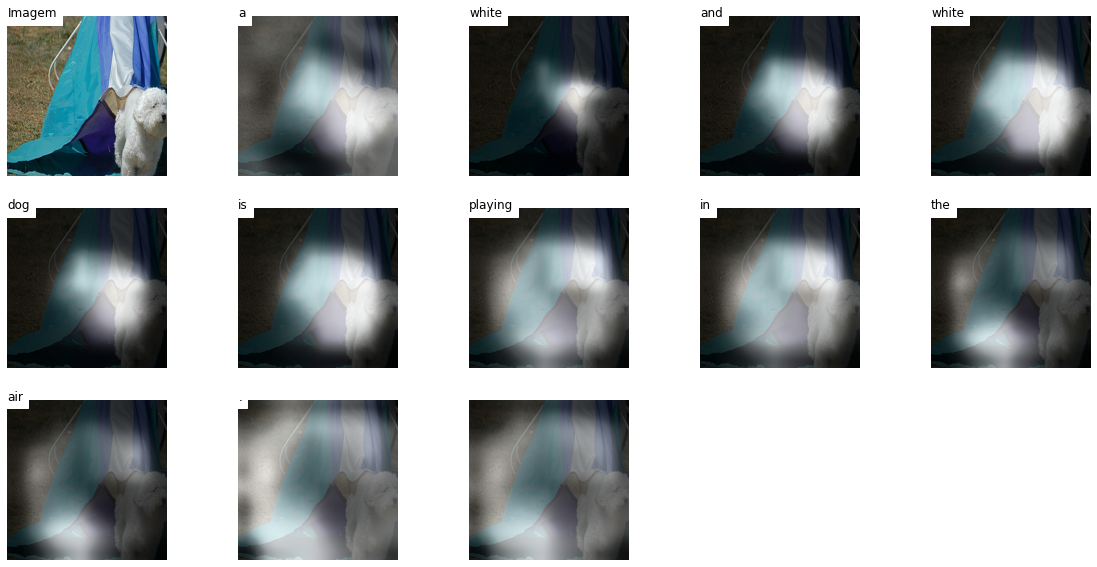

In [55]:
IMAGE = '/Images/1355935187_2c99648138.jpg'
seq, alphas = caption_image_beam_search(
    encoder, decoder, 
    IMAGE, dataset.vocab, 5
)

alphas = torch.FloatTensor(alphas)
rev_word_map = {k:v for k, v in dataset.vocab.itos.items()}
visualize_att(IMAGE, seq, alphas, rev_word_map)